# Example PCMCI+

## Setup

In [24]:
import glob
import os
import subprocess
import pickle as cPickle
import ast
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pickle
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import numpy as np
import sklearn
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
import pandas as pd
import seaborn as sns


In [25]:
#path depending on timebin
pca_res_path="./c-transfer"
pcmci_res_path="./output"
f1_scores_path="./output_f1-scores/f1scores_new1_causalOnly"
model_names=['ACCESS-CM2', 'BCC-CSM2-MR', 'CanESM5', 'CESM2', 'CNRM-CM6-1', 'EC-Earth3', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC-ES2L',
             'MPI-ESM1-2-HR', 'UKESM1-0-LL']


In [26]:
related_models=[] #wie am besten machen, falls überhaupt so? Hier mal als Äquivalenzklassen
related_models.append((0, 6, 10))
related_models.append((1,))
related_models.append((2,))
related_models.append((3,))
related_models.append((4,))
related_models.append((5,))
related_models.append((0, 6, 10))
related_models.append((7,))
related_models.append((8,))
related_models.append((9,))
related_models.append((0, 6, 10))

In [27]:
f1Scores={}
for file in os.listdir(f1_scores_path):
    f1_scores_single_path=os.path.join(f1_scores_path, file)
    f1_scores_single=pickle.load(open(f1_scores_single_path,"rb"))
    pc_alpha=f1_scores_single['pc_alpha']
    n_kept_comp=f1_scores_single['n_kept_comp']
    f1Scores[(pc_alpha, n_kept_comp)]=f1_scores_single['f1Scores']    

In [28]:
f1Scores_={} #f1Scores sortiert bzw. die einträge der keys sortiert nach alpha_value
for key in f1Scores:
    scores=f1Scores[key]
    tempList={}
    for element in scores:
        for key2 in element:
            tempList[key2]=element[key2]
    sorted_dict = dict(sorted(tempList.items()))
    f1Scores_[key]=sorted_dict
    

In [29]:
avg_f1_scores_models={} #avg F1-Score for each refModel F1-Matrix
for key in f1Scores_:
    scores=f1Scores_[key]
    avg_f1_scores_models.setdefault(key, {})
    for key2 in scores:
        avg_f1_scores_models[key][key2]=np.nanmean(scores[key2], axis=(2, 3)) #also avg f1 score für key1=pc_alpha und key2=refDataSet

In [30]:
#metric1 for all refDatasets. Returns average f1-score-metric1-distance for all refDatasets
def metric1(f1scores): #f14d matrix
    result=[]
    for i,refDataset in enumerate(f1scores):
        scores=f1scores[i]
        min_scores=[]
        max_scores=[]
        for element in scores:
            arr=np.array(element)
            min_scores.append(np.nanmin(arr))
            max_scores.append(np.nanmax(arr))
        result.append(np.mean(np.subtract(max_scores, min_scores)))
    return result

In [31]:
def metric2_(key, f1scores, relModelsTuple, refModelIndex, alphaValue):#f1scores for specific model for testing! not full matrix
    avgF1Distance = np.full((len(relModelsTuple), len(model_names)), np.nan)
    for i, modelIndex in enumerate(relModelsTuple):
        for j, model in enumerate(model_names):
            if j not in relModelsTuple:
                val=abs(avg_f1_scores_models[key][alphaValue][refModelIndex][modelIndex]-avg_f1_scores_models[key][alphaValue][refModelIndex][j])
                avgF1Distance[i][j]=val
                                        
    return avgF1Distance, np.nanmean(avgF1Distance)
        
    
    

In [32]:
def metric2(key, alphaValue):#f1scores for specific model for testing! not full matrix
    avgF1DistanceFinal=[]
    for refModelIndex, model in enumerate(model_names):
        relModelsTuple=related_models[refModelIndex]
        avgF1Distance = np.full((len(relModelsTuple), len(model_names)), np.nan)
        for i, modelIndex in enumerate(relModelsTuple):
            for j, model in enumerate(model_names):
                if j not in relModelsTuple:
                    val=abs(avg_f1_scores_models[key][alphaValue][refModelIndex][modelIndex]-avg_f1_scores_models[key][alphaValue][refModelIndex][j])
                    avgF1Distance[i][j]=val
        avgF1DistanceFinal.append(np.nanmean(avgF1Distance))
    #print(key, np.nanmean(np.array(avgF1DistanceFinal)))
    return np.array(avgF1DistanceFinal), np.nanmean(np.array(avgF1DistanceFinal))
        
    
    

In [33]:
def plot_metric2_div_metric1(key):
    # Gleichmäßig verteilte x-Werte erstellen
    values=metric2_div_metric1[key]
    x_values, y_values = zip(*values)
    x_values=list(x_values)
    
    for element in x_values:
        element=np.log10(element)
        
    y_values=list(y_values)
    x_uniform = np.linspace(min(x_values), max(x_values), len(x_values))
    labels=x_values

    # Plot erstellen
    plt.plot(x_uniform, y_values, marker='o', linestyle='-')

    # Labels hinzufügen
    for i, txt in enumerate(labels):
        plt.annotate(txt, (x_uniform[i], y_values[i]), textcoords="offset points", xytext=(0,10), ha='center')
        
    plotTitle='Nr. of components: ' + str(key[1]) + ', pc_alpha: ' + str(key[0])
    plt.title(plotTitle)
    plt.ylabel('F1-Score')
    plt.figtext(0, 0, 'The resulting M2/M1 for N components, specific pc_alpha (see title) and different alpha_values vizualized')

    plt.ylim(0, 3)
    
    # Plot anzeigen
    plt.show()

In [34]:
metric1Mins={} #Mins for the metric1 mean values per (alphaValue, n_kept_comp)
for key in f1Scores_:
    metric1values=[]
    f1_score_single=f1Scores_[key] 
    for key2 in f1_score_single:
        metric1values.append(   (key2, np.mean((metric1(f1_score_single[key2]))))   )
        if key[1]==100 and key2==0.0005:
            metric1_vs_pcAlpha.append((key[0], np.mean((metric1(f1_score_single[key2])))))
    metric1Mins[key]=min(metric1values, key = lambda t: t[1])

In [35]:
metric2Maxs={}
for key in f1Scores_:
    metric2values=[]
    f1_score_single=f1Scores_[key]
    for key2 in f1_score_single:
        #metric2values.append((key2, metric2_(key, None, related_models[0], 6, key2)[1]))
        metric2values.append((key2, metric2(key, key2)[1]))
        if key[1]==100 and key2==0.0005:
            metric2_vs_pcAlpha.append((key[0], metric2(key, key2)[1]))
    metric2Maxs[key]=max(metric2values, key = lambda t: t[1])

In [36]:
metric2_div_metric1_maxs={}
m2_div_m1_o={}
metric2_div_metric1={}
for key in f1Scores_:
    metric2divmetric1values=[]
    f1_score_single=f1Scores_[key]
    metric2_div_metric1.setdefault(key, [])
    for key2 in f1_score_single:
        m1=np.mean(metric1(f1_score_single[key2]))
        #m2=metric2_(key, None, related_models[0], 6, key2)[1]
        m2=metric2(key, key2)[1]
        m2_o=metric2(key, key2)[0]
        metric2divmetric1values.append((key2, m2/m1, m2, m1))
        metric2_div_metric1[key].append((key2, m2/m1))
        m2_div_m1_o[(key, key2)]=(m2/m1, m2, m2_o, np.std(m2_o, ddof=0))
    metric2_div_metric1_maxs[key]=max(metric2divmetric1values, key = lambda t: t[1])

In [37]:
metric2_div_metric1_maxs_2={} #(comps, pc_alpha, alpha_value): F1-Score  wobei alpha_value für den max erreichten F1-Score gegeben ist
for key in metric2_div_metric1_maxs:
    pc_alpha=key[0]
    comps=key[1]
    alpha_value=metric2_div_metric1_maxs[key][0]
    metric2_div_metric1_maxs_2[(comps,pc_alpha,alpha_value)]=metric2_div_metric1_maxs[key]

In [38]:
sorted_dict_komps = dict(sorted(metric2_div_metric1_maxs_2.items(), key=lambda x: x[0][0])) #sortiert nach comps, dann pc_alpha

In [39]:
temp = sorted(sorted_dict_komps.items(), key=lambda x: x[1][1])
#temp

In [40]:
metric2_div_metric1=dict(sorted(metric2_div_metric1.items(), key=lambda x: x[0][1]))

In [41]:
temp={}
#pc_lpha, comps = zip((list(metric2_div_metric1_maxs.keys())))
temp2=list(metric2_div_metric1_maxs.keys())
pc_alpha, comps = zip(*temp2)
pc_alpha=list(set(pc_alpha))
comps=list(set(comps))
for key in comps:
    temp.setdefault(key, [])
    
for key in metric2_div_metric1_maxs:
    temp[key[1]].append((key[0], metric2_div_metric1_maxs[key][1]))
    
temp=dict(sorted(temp.items()))

In [43]:
from collections import OrderedDict

sorted_dict = OrderedDict(sorted(metric2_div_metric1_maxs_2.items(), key=lambda item: item[1][1]))
#sorted_dict

In [47]:
def scatter_plot_2(data,model_nr,title,name,save_name,vmin,vmax,nr_intervals,label):
    size_s=40
    nr_models=len(data[:,0,0,0])
    average=0
    n_ensembles=nr_intervals
    all_values = []  # Hier werden alle Werte gesammelt

    for i in range(0,nr_models):
#         print i                                                                                                                                                                                                                                                           
#         if name[i]==name[model_nr]:                                                                                                                                                                                                                                       
#             print name[i]                                                                                                                                                                                                                                                 
        if name[i] in ['era', 'NCEP']: #2*datashape 3
            plt.scatter(np.ones((nr_intervals**2))*i,data[model_nr,i,:,:].flatten(),color='red',s=size_s)
#             print name[i],np.nanmean(data[model_nr,i,:,:],axis=(0,1))                                                                                                                                                                                                     
            if i==model_nr:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='r',linewidth=2,s=size_s)
            else:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)
        else:
#             print name[i],data[model_nr,i,:,:].flatten()[0:n_ensembles]                                                                                                                                                                                                   
            plt.scatter(np.ones(4*4)*i,data[model_nr,i,:,:].flatten(),color='red',s=size_s)
#             print name[i],np.nanmean(data[model_nr,i,:,:],axis=(0,1))                                                                                                                                                                                                     
            if i==model_nr:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='r',linewidth=2,s=size_s)
            else:
                average+=np.nanmean(data[model_nr,i,:,:],axis=(0,1))
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)
        all_values.extend(data[model_nr, i, :, :].flatten())

    min_value = np.nanmin(all_values)
    max_value = np.nanmax(all_values)

    
    
    #### REVISE
    average/=(nr_models-1) #    average/=double(nr_models-1)
    print('average', average)
    plt.plot(np.linspace(-0.5,nr_models+1,100)-0.25,np.ones((100))*average,color='gray',linestyle='--',linewidth=2)
    plt.xticks(np.arange(0,nr_models),name[:],rotation=90,size=12)
    plt.ylabel(label,size=16,fontweight='bold')
    plt.xlim(-0.5,nr_models-0.5)
    #plt.ylim(vmin,vmax)
    plt.ylim(max(0, min_value-0.1), min(1, max_value+0.1))
    plt.title('Reference: ' + model_names[model_nr], fontweight='bold', size=12)
    plt.show()
    plt.close()

In [45]:
def scatter_plot_2_(data, model_nr, title, name, save_name, vmin, vmax, nr_intervals, label):
    size_s = 40
    nr_models = len(data[:, 0, 0, 0])
    average = 0
    n_ensembles = nr_intervals
    all_values = []  

    for i in range(0, nr_models):
        if name[i] in ['era', 'NCEP']:
            plt.scatter(np.ones((nr_intervals**2)) * i, data[model_nr, i, :, :].flatten(), color='red', s=size_s)
            if i == model_nr:
                plt.scatter(i, np.nanmean(data[model_nr, i, :, :], axis=(0, 1)), marker='x', color='k', linewidth=2, s=size_s)
            else:
                plt.scatter(i, np.nanmean(data[model_nr, i, :, :], axis=(0, 1)), marker='x', color='k', linewidth=2, s=size_s)
        else:
            plt.scatter(np.ones(4*4) * i, data[model_nr, i, :, :].flatten(), color='red', s=size_s)
            if i == model_nr:
                plt.scatter(i, np.nanmean(data[model_nr, i, :, :], axis=(0, 1)), marker='x', color='k', linewidth=2, s=size_s)
            else:
                average += np.nanmean(data[model_nr, i, :, :], axis=(0, 1))
                plt.scatter(i, np.nanmean(data[model_nr, i, :, :], axis=(0, 1)), marker='x', color='k', linewidth=2, s=size_s)
        all_values.extend(data[model_nr, i, :, :].flatten())

    min_value = np.nanmin(all_values)
    max_value = np.nanmax(all_values)

    average /= (nr_models - 1)
    plt.plot(np.linspace(-0.5, nr_models + 1, 100) - 0.25, np.ones((100)) * average, color='gray', linestyle='--', linewidth=2)
    plt.xticks(np.arange(0, nr_models), name[:], rotation=90, size=12)
    plt.ylabel(label, size=16, fontweight='bold')
    plt.xlim(-0.5, nr_models - 0.5)
    plt.ylim(min_value-100, max_value+100) 
    plt.title('Reference: ' + model_names[model_nr], fontweight='bold', size=12)
  #  plt.savefig('./images/gridSearch/' + title + '.png', dpi=600)
    plt.show()
    plt.close()

## Visualization

(25, 0.025, 1e-10)
average 0.3456457539505199


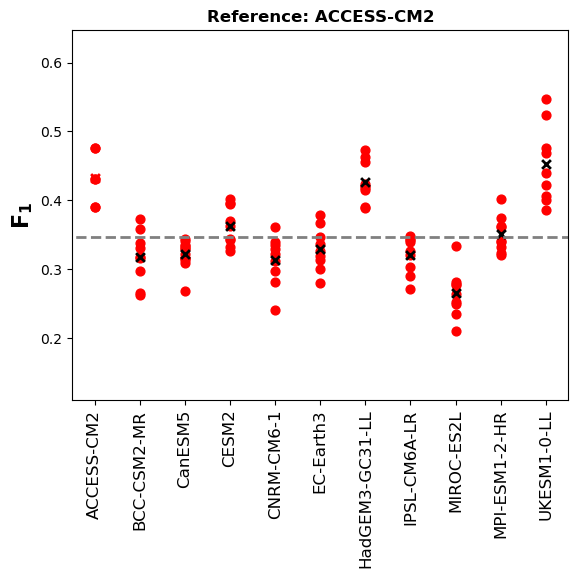

average 0.3061504192052347


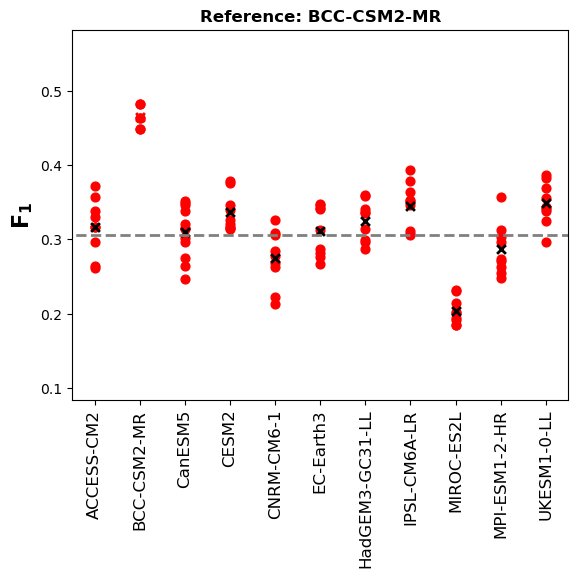

average 0.28721551682217483


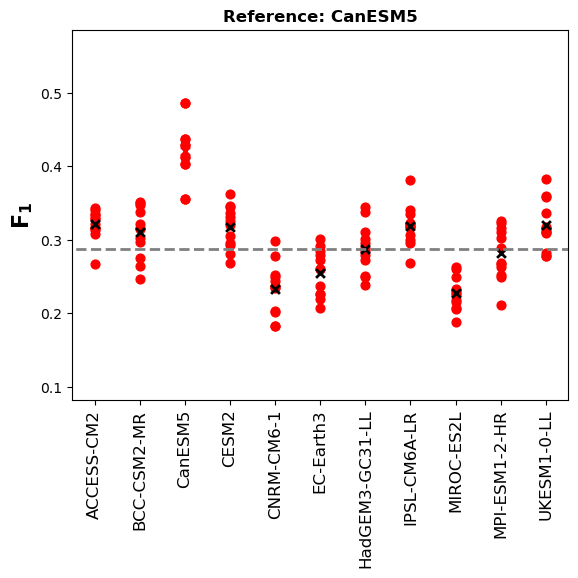

average 0.3258210848788744


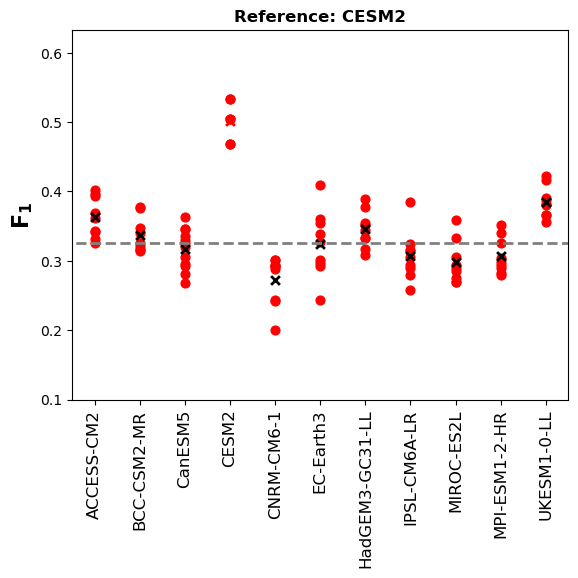

average 0.29707926589309913


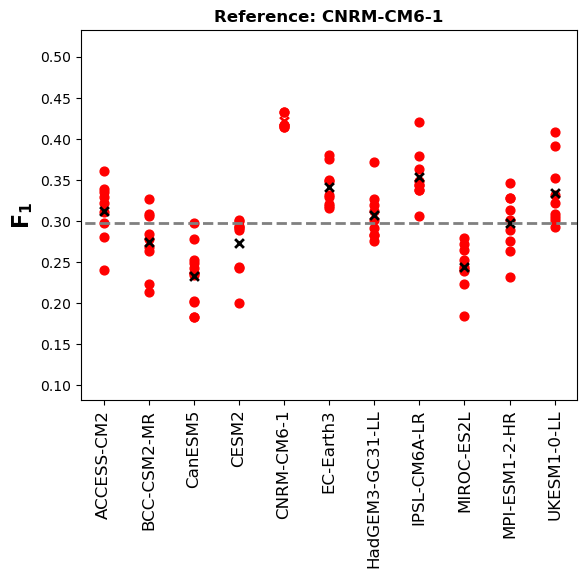

average 0.32412064593695483


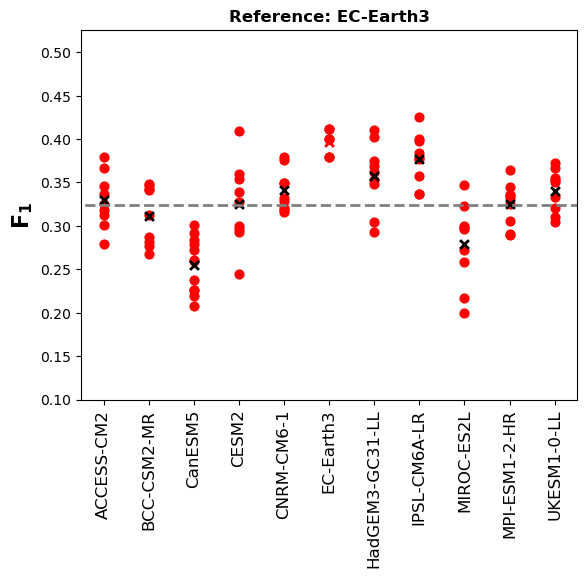

average 0.34457550154779615


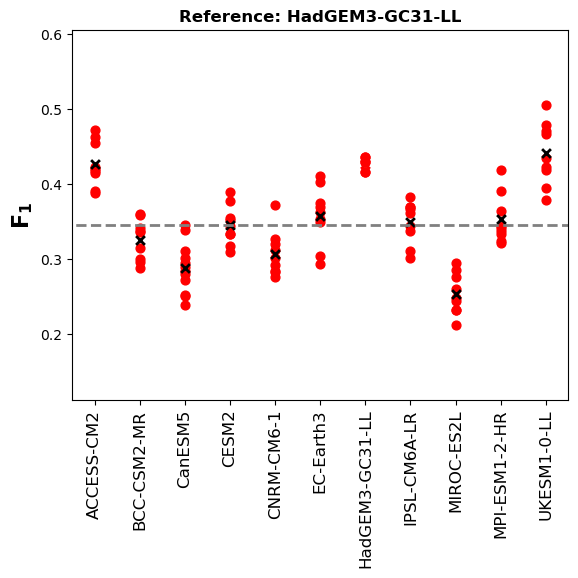

average 0.3316192345404964


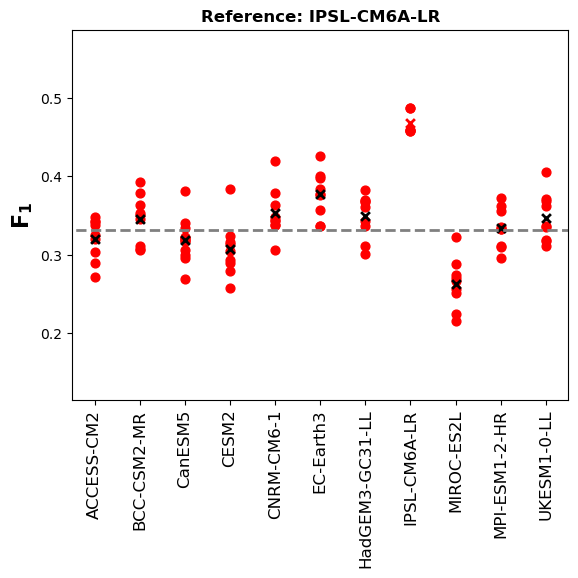

average 0.25773291544438776


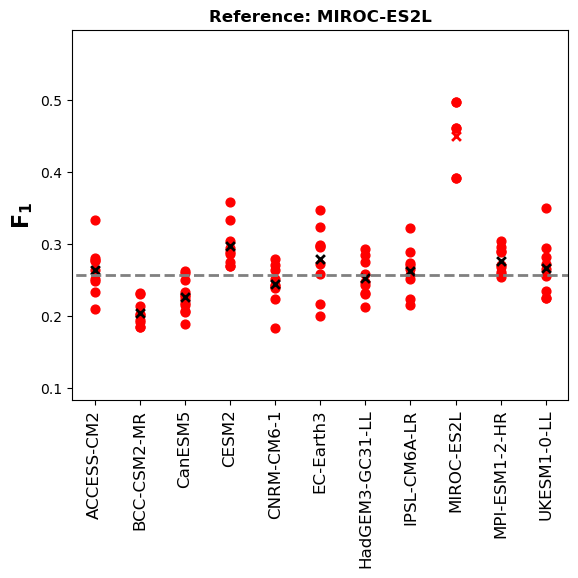

average 0.315662433955615


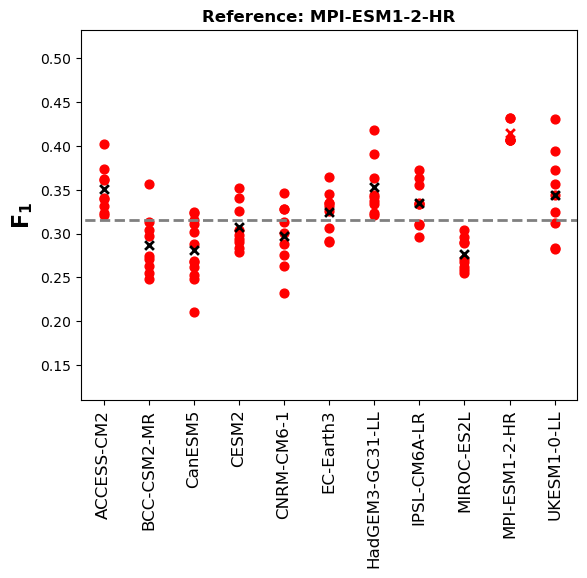

average 0.3581095653389107


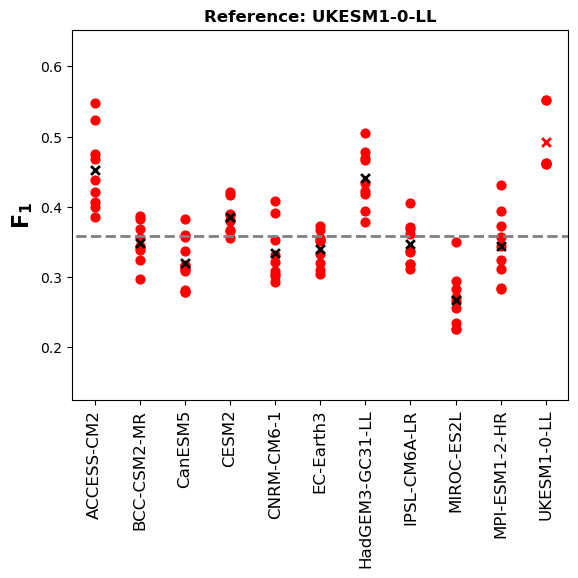

(50, 0.02, 1e-10)
average 0.4405380369453159


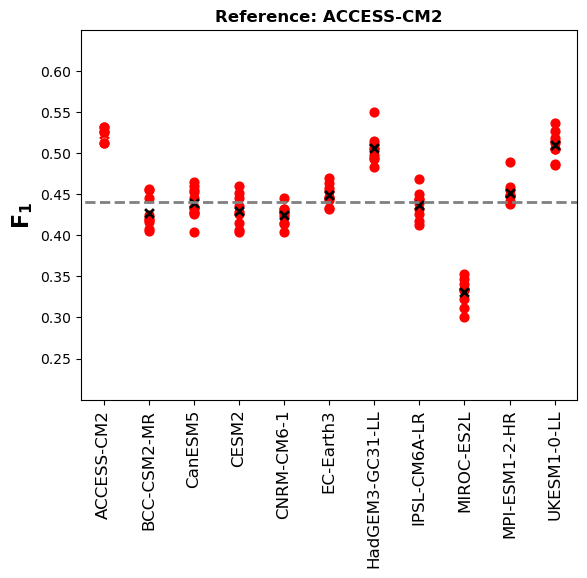

average 0.40252073532693344


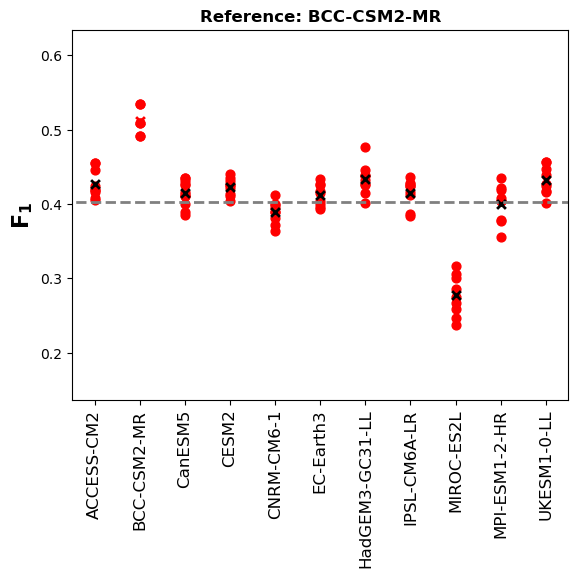

average 0.3988116383791


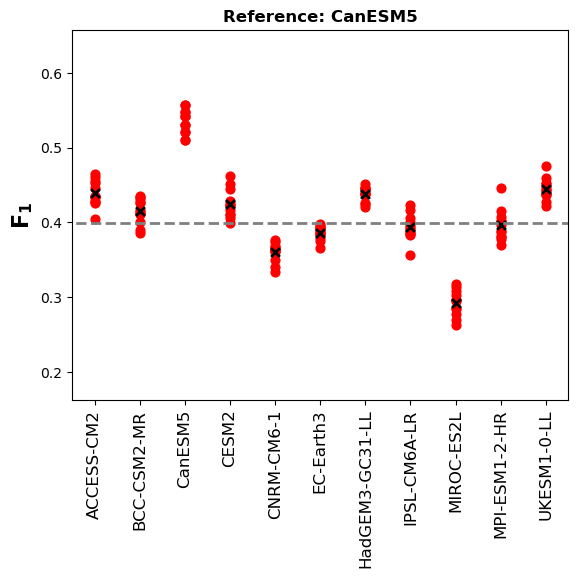

average 0.39074304147835587


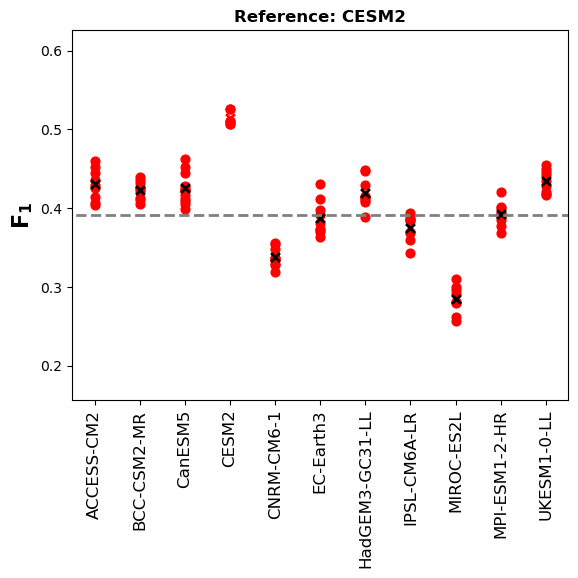

average 0.40265048227526873


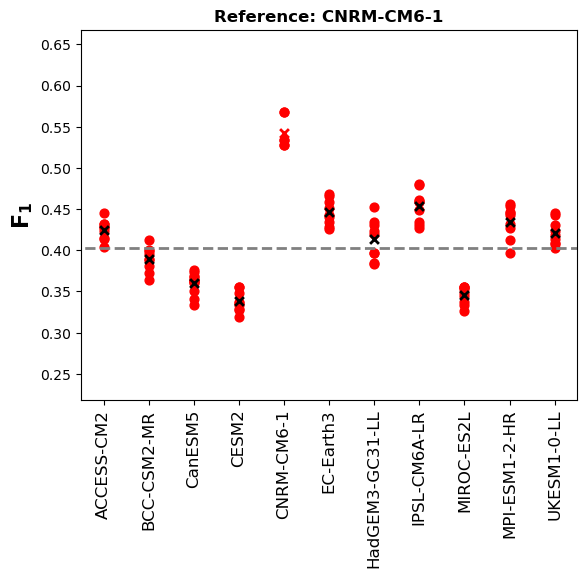

average 0.4231747627995035


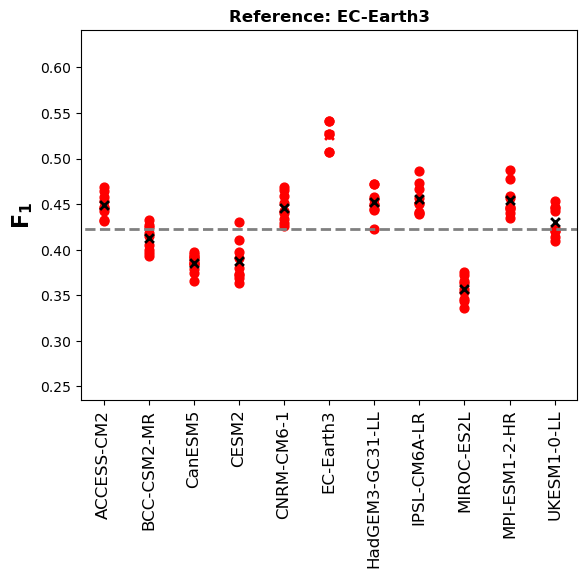

average 0.4380404988919947


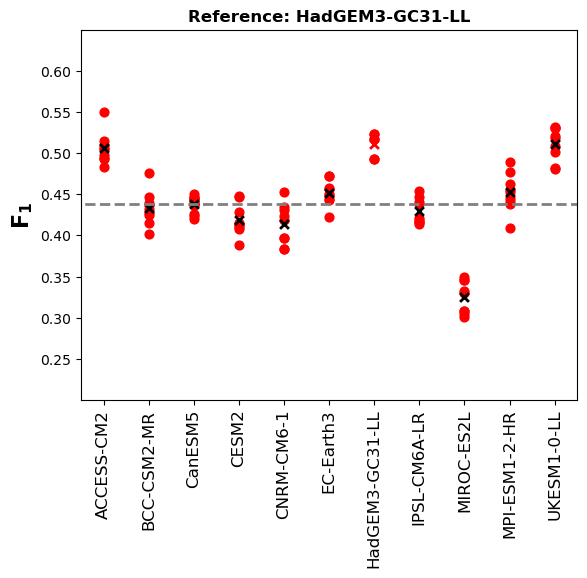

average 0.41718409786344557


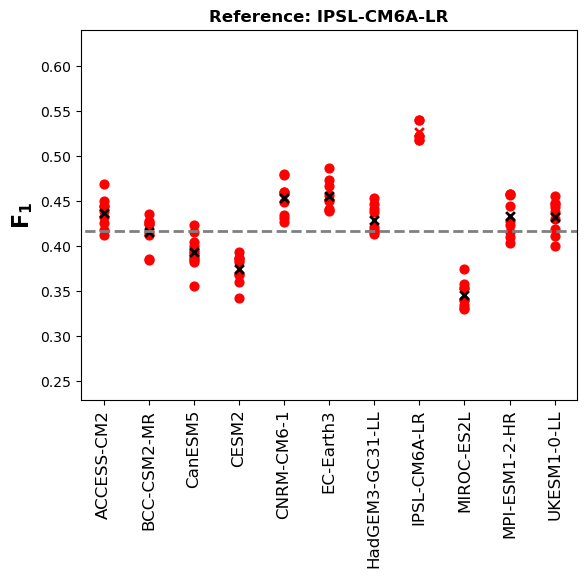

average 0.3209273557232645


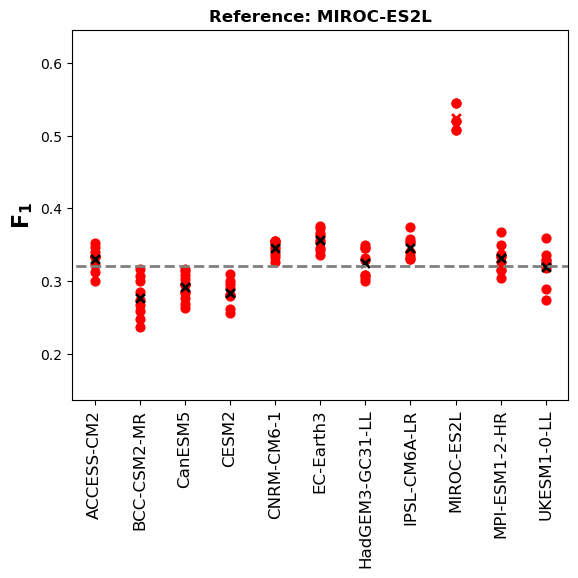

average 0.4183589725447436


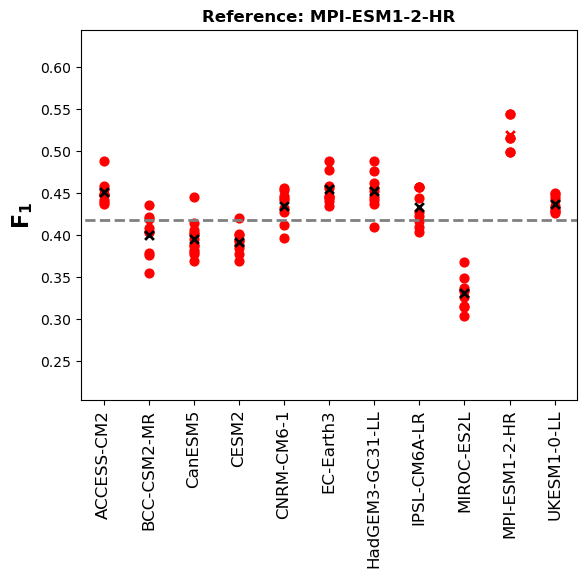

average 0.43744221522708837


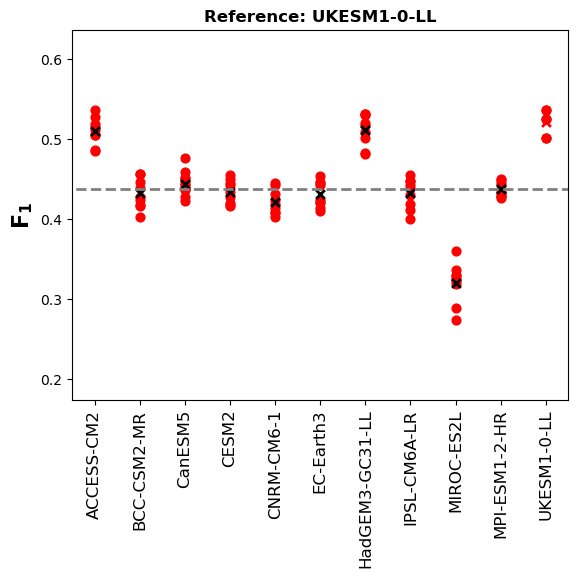

In [48]:
for key in sorted_dict_komps: #or choose one key instead of loop over all
    print(key)
    for refModelIndex, model in enumerate(model_names):
        scatter_plot_2(f1Scores_[(key[1],key[0])][key[2]], refModelIndex, "comps: " + str(key[0]) + "|pc_alpha: " + str (key[1]) + "|alpha_value: " + str(key[2]), model_names, 'scatterplot2', 0.5, 1, 3, r'F$_{\mathbf{1}}$')